# Le Debruiteur
* Jonas Freiburghaus
* Romain Capocasale
* He-Arc, INF3dlm-a
* Image Processing course
* 2019-2020

## Statistics

In [1]:
import os

from debruiteur.generator.datagenerator import DataGenerator
from debruiteur.preprocessing.preprocessor import make_original_dataframe, make_resized_dataframe, make_noised_dataframe
from debruiteur.noise.noise import GaussianNoise, PoissonNoise, UniformNoise, SaltPepperNoise, SquareMaskNoise, SpeckleNoise
from debruiteur.utils.utils import load_model, split_train_val_df
from debruiteur.noise.filters import gaussian_filter, wiener_filter, laplacian_filter, gaussian_weighted_substract_filter, mean_filter, median_filter, conservative_filter, low_pass_filter
from debruiteur.statistics.statistics import compute_noise_reduction_method_statistics, compute_noise_type_statistics
from debruiteur.metrics.metrics import metrics_example

In [2]:
noise_class_list = [
    GaussianNoise(mean=0, std=20),
    PoissonNoise(),
    UniformNoise(amplitude=100),
    SaltPepperNoise(),
    SquareMaskNoise(mask_shape=(10, 10), freq=0.1),
    SpeckleNoise(),
]

### Load data

In [3]:
working_dir = os.path.abspath(os.getcwd())

df_original = make_original_dataframe(os.path.join(working_dir, "images"))
df_resized = make_resized_dataframe(df_original, img_shape=(100, 100), resized_path=os.path.join(working_dir, "resized_images"))
df_noised = make_noised_dataframe(df_resized, noise_class_list, os.path.join(working_dir, "noised_images"))

### Metrics

Mean squared error (MSE) :
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Normalized root mean squared error (NRMSE) :
$$\text{NRMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log{\frac{\hat{y} + 1}{y + 1}}\right)^2}$$

Peak signal to noise ration (PSNR) :
$$\text{PSNR} = 10 \log_{10} \left( \frac{{MAX_{I}^2}}{MSE} \right)$$

Structural similarity (SSIM) :
$$\text{SSIM(x, y)} = \frac{(2\mu_x \mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$$

### Show metrics example

C:\Users\Romain\Desktop\ProjetHeArc\ledebruiteur\debruiteur\metrics\metrics.py:65: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim = metrics.structural_similarity(orignal_img, noised_img)


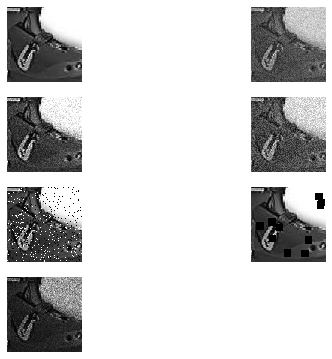

,Noise,MSE,NRMSE,PSNR,SSIM
0,GaussianNoise,400.659958,0.147407,22.103044,0.432597
1,PoissonNoise,244.782100,0.115218,24.243007,0.502219
2,UniformNoise,3325.082540,0.424651,12.912779,0.299032
3,SaltPepperNoise,2367.824700,0.358349,14.387308,0.269416
4,SquareMaskNoise,1880.118500,0.319318,15.388951,0.804946
5,SpeckleNoise,739.790029,0.200302,19.439719,0.499826


In [4]:
metrics_example(df_noised, noise_class_list)

You can see the score for each type of noise for each metric. We can notice that the type of noise that deteriorates the image the most is SpeckleNoise. We can also see that the Gaussian, Poisson noise is one of the filters that deteriorates the image the least. 

### Create data generator

In [5]:
stats_gen = DataGenerator(df_noised[0:20], batch_size=20)

### Load models

In [6]:
conv_ae_model = load_model(os.path.join(working_dir, "saved_models"), "conv_autoencoder.h5")
dense_ae_model = load_model(os.path.join(working_dir, "saved_models"), "dense_autoencoder.h5")
gan_model = load_model(os.path.join(working_dir, "saved_models"), "gan_generator.h5")

C:\Users\Romain\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\layers\core.py:986: UserWarning: debruiteur.models.gan is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### Noise reduction methods
After the output of the neural networks we apply a filter to smooth the image. Indeed, the images at the output of the neural network are a little blurred. These filters allow to reduce the blur. The filters used are : 
* Wiener filter
* Laplacian filter
* Gaussian Weigthed filter

In [38]:

noise_reduction_methods = [('Gaussian Filter', lambda img: gaussian_filter(img * 255)),
                           ('Mean Filter', lambda img: mean_filter(img * 255)),
                           ('Median Filter', lambda img: median_filter(img * 255)),
                           ('Conservative Filter', lambda img: conservative_filter(img * 255)),
                           ('Low pass FFT Filter', lambda img: low_pass_filter(img * 255)),
                           
                           ('Convolutional Autoencoder None', lambda x : conv_ae_model.predict(x.reshape(1, 100, 100, 1)) * 255),
                           ('Convolutional Autoencoder Wiener', lambda x : wiener_filter(conv_ae_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),
                           ('Convolutional Autoencoder Laplacian', lambda x : laplacian_filter(conv_ae_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),
                           ('Convolutional Autoencoder Gaussian Weighted', lambda x : gaussian_weighted_substract_filter(conv_ae_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),

                           ('Dense Autoencoder', lambda x : dense_ae_model.predict(x.reshape(1, 10000)) * 255),

                           ('Generative Adversarial Network None', lambda x : gan_model.predict(x.reshape(1, 100, 100, 1)) * 255),
                           ('Generative Adversarial Network Wiener', lambda x : wiener_filter(gan_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),
                           ('Generative Adversarial Network Laplacian', lambda x : laplacian_filter(gan_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255)),
                           ('Generative Adversarial Network Weighted', lambda x : gaussian_weighted_substract_filter(gan_model.predict(x.reshape(1, 100, 100, 1)).reshape(100,100) * 255))]

### Noise reduction methods metrics averaged on all kind of noises

In [39]:
compute_noise_reduction_method_statistics(stats_gen, noise_reduction_methods)

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,MSE,NRMSE,PSNR,SSIM
Gaussian Filter,1383.751598,0.270366,17.821248,0.537968
Mean Filter,1643.894664,0.301545,16.659133,0.388854
Median Filter,1606.981710,0.294900,16.981278,0.427898
Conservative Filter,1363.100250,0.257813,18.539934,0.644942
Low pass FFT Filter,1291.788832,0.256989,18.370414,0.589714
Convolutional Autoencoder None,2802.652966,0.398682,14.180875,0.192945
Convolutional Autoencoder Wiener,3707.112167,0.464370,12.664991,0.155273
Convolutional Autoencoder Laplacian,2829.643444,0.401648,14.093179,0.179581
Convolutional Autoencoder Gaussian Weighted,2857.355562,0.402090,14.107625,0.197319
Dense Autoencoder,5590.364449,0.574517,10.738397,0.008348


### Noise reductions methods for each noise type
#### Structural similarity (SSIM)

A high SSIM is desired

In [40]:
df_stat_ssim = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "SSIM")
df_stat_ssim

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Gaussian Filter,0.480861,0.594786,0.466360,0.454032,0.567115,0.427490
Mean Filter,0.330425,0.427043,0.334962,0.352940,0.386881,0.294175
Median Filter,0.361592,0.459697,0.337228,0.525878,0.448101,0.306368
Conservative Filter,0.623448,0.711562,0.542842,0.514673,0.832745,0.581623
Low pass FFT Filter,0.577323,0.667556,0.542019,0.461540,0.640722,0.529786
Convolutional Autoencoder None,0.171184,0.171369,0.169248,0.135719,0.141315,0.050251
Convolutional Autoencoder Wiener,0.154019,0.142477,0.151662,0.120629,0.117235,0.086945
Convolutional Autoencoder Laplacian,0.153079,0.161674,0.152466,0.128188,0.135448,0.047118
Convolutional Autoencoder Gaussian Weighted,0.179107,0.176304,0.178567,0.135375,0.153288,0.056966
Dense Autoencoder,0.007687,0.008676,0.007888,0.008504,0.008181,0.007620


In [41]:
df_stat_ssim.mean(axis=1).sort_values()

Dense Autoencoder                              0.008093
Convolutional Autoencoder Wiener               0.128828
Convolutional Autoencoder Laplacian            0.129662
Convolutional Autoencoder None                 0.139848
Convolutional Autoencoder Gaussian Weighted    0.146601
Generative Adversarial Network Laplacian       0.165216
Generative Adversarial Network Wiener          0.319610
Mean Filter                                    0.354404
Median Filter                                  0.406477
Generative Adversarial Network None            0.453151
Generative Adversarial Network Weighted        0.488136
Gaussian Filter                                0.498441
Low pass FFT Filter                            0.569825
Conservative Filter                            0.634482
dtype: float64

#### Peak signal-to-noise ratio (PSNR)

A High PSNR is desired but not in all cases. It is often used as a reconstruction loss when compressing images.

In [42]:
df_stat_psnr = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "PSNR")
df_stat_psnr

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Gaussian Filter,17.794521,21.491146,18.251684,19.303878,16.002743,13.555615
Mean Filter,16.762252,19.314265,17.166134,18.484490,15.857785,13.169582
Median Filter,17.224598,20.051869,17.453034,20.092733,15.335800,12.897153
Conservative Filter,19.134555,24.192586,18.630952,15.883735,16.618721,13.857679
Low pass FFT Filter,18.674284,22.623434,18.777573,17.832793,16.425489,13.551561
Convolutional Autoencoder None,13.206820,13.372051,13.367346,12.127501,11.781355,8.858734
Convolutional Autoencoder Wiener,12.987626,12.275291,12.909715,11.461688,11.253832,10.666184
Convolutional Autoencoder Laplacian,13.289694,13.279371,13.229539,12.105405,11.924142,8.759120
Convolutional Autoencoder Gaussian Weighted,13.435488,13.353022,13.438697,12.077711,11.884156,8.843888
Dense Autoencoder,10.754136,10.719753,10.755382,10.730888,10.686818,10.671369


In [43]:
df_stat_psnr.mean(axis=1).sort_values()

Dense Autoencoder                              10.719724
Convolutional Autoencoder Wiener               11.925723
Convolutional Autoencoder Laplacian            12.097878
Convolutional Autoencoder None                 12.118968
Convolutional Autoencoder Gaussian Weighted    12.172161
Generative Adversarial Network Laplacian       12.618083
Generative Adversarial Network None            13.314189
Generative Adversarial Network Weighted        13.368553
Generative Adversarial Network Wiener          13.782525
Mean Filter                                    16.792418
Median Filter                                  17.175865
Gaussian Filter                                17.733264
Low pass FFT Filter                            17.980856
Conservative Filter                            18.053038
dtype: float64

#### Mean squared error (MSE)

A low MSE is desired.

In [44]:
df_stat_mse = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "MSE")
df_stat_mse

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Gaussian Filter,1094.259272,494.218963,996.627654,788.076802,1791.656928,3029.674543
Mean Filter,1387.161163,804.300226,1280.985426,953.033725,1972.719560,3215.963001
Median Filter,1272.079571,697.821300,1188.284437,690.000552,2186.663699,3326.557802
Conservative Filter,804.473283,252.737963,896.611126,1722.363353,1733.089590,2795.505036
Low pass FFT Filter,938.699220,365.486009,864.479191,1068.343812,1476.243403,2837.283049
Convolutional Autoencoder None,3064.476818,3043.804385,3030.528130,4058.830963,4102.306838,8742.653994
Convolutional Autoencoder Wiener,3436.372036,3920.166668,3366.883140,4681.198022,5050.495058,5518.459804
Convolutional Autoencoder Laplacian,3138.026008,3113.426767,3128.245455,4041.852881,4118.701257,8716.348120
Convolutional Autoencoder Gaussian Weighted,2925.070390,3047.501437,2965.767381,4068.155954,4519.686630,8605.910887
Dense Autoencoder,5571.289693,5617.769457,5568.000281,5598.676729,5625.017617,5681.814895


In [45]:
df_stat_mse.mean(axis=1).sort_values()

Low pass FFT Filter                            1258.422447
Gaussian Filter                                1365.752360
Conservative Filter                            1367.463392
Median Filter                                  1560.234560
Mean Filter                                    1602.360517
Generative Adversarial Network Wiener          2935.552495
Generative Adversarial Network None            3394.690022
Generative Adversarial Network Weighted        3470.791553
Generative Adversarial Network Laplacian       3920.274295
Convolutional Autoencoder Wiener               4328.929121
Convolutional Autoencoder None                 4340.433521
Convolutional Autoencoder Gaussian Weighted    4355.348780
Convolutional Autoencoder Laplacian            4376.100081
Dense Autoencoder                              5610.428112
dtype: float64

#### Root mean squared error (RMSE)

A low RMSE is desired.

In [46]:
df_stat_rmse = compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "NRMSE")
df_stat_rmse

Compute finish for Gaussian Filter
Compute finish for Mean Filter
Compute finish for Median Filter
Compute finish for Conservative Filter
Compute finish for Low pass FFT Filter
Compute finish for Convolutional Autoencoder None
Compute finish for Convolutional Autoencoder Wiener
Compute finish for Convolutional Autoencoder Laplacian
Compute finish for Convolutional Autoencoder Gaussian Weighted
Compute finish for Dense Autoencoder
Compute finish for Generative Adversarial Network None
Compute finish for Generative Adversarial Network Wiener
Compute finish for Generative Adversarial Network Laplacian
Compute finish for Generative Adversarial Network Weighted


,GaussianNoise,PoissonNoise,UniformNoise,SaltPepperNoise,SquareMaskNoise,SpeckleNoise
Gaussian Filter,0.257595,0.169933,0.243462,0.214122,0.328460,0.420099
Mean Filter,0.286915,0.217256,0.275429,0.237787,0.328977,0.438955
Median Filter,0.271488,0.200796,0.265759,0.200210,0.347382,0.445373
Conservative Filter,0.216439,0.121859,0.230935,0.323708,0.296295,0.403353
Low pass FFT Filter,0.232080,0.147028,0.227438,0.256398,0.284724,0.420057
Convolutional Autoencoder None,0.423720,0.425222,0.422731,0.491026,0.493129,0.713022
Convolutional Autoencoder Wiener,0.443712,0.482101,0.443031,0.523587,0.553327,0.571523
Convolutional Autoencoder Laplacian,0.430131,0.429703,0.431168,0.494138,0.499792,0.711085
Convolutional Autoencoder Gaussian Weighted,0.406768,0.426333,0.418233,0.489842,0.501132,0.712196
Dense Autoencoder,0.573443,0.575756,0.573310,0.575143,0.575057,0.579049


In [47]:
df_stat_rmse.mean(axis=1).sort_values()

Low pass FFT Filter                            0.261287
Conservative Filter                            0.265432
Gaussian Filter                                0.272279
Median Filter                                  0.288501
Mean Filter                                    0.297553
Generative Adversarial Network Wiener          0.409209
Generative Adversarial Network Weighted        0.430514
Generative Adversarial Network None            0.431588
Generative Adversarial Network Laplacian       0.466983
Convolutional Autoencoder Gaussian Weighted    0.492417
Convolutional Autoencoder None                 0.494808
Convolutional Autoencoder Laplacian            0.499336
Convolutional Autoencoder Wiener               0.502880
Dense Autoencoder                              0.575293
dtype: float64

# Conclusion

As we can observe the conservative filter has the best score on all most all type of noises.  
It may be because the changes in the images are very small so it the denoised image is similar to the original image.  
This is particularly true when the images are not very noised and the performance would be different if the images had more noise.  

The generative adversial neural network reduces the noise quite well, but as the image is generated, the colors are sometimes different which is not the case of other filters.  
When we sum all these small differences pixelwise it is expected to have a high error.  
Even though the results are visually good.  

For each filter the metrics where computed on all kind of noises.  
Usually we should use a specific filter on a particular noise as they perform better on the approriate noise.  

Comparing the neural networks, the generative adversial neural network has the best performances.  
If we had a GPU with more RAM, we could increase the depth of the GAN by putting more convolutional blocks.  
This is also the reason why we reduced the image's size to 100x100 and used grayscale.  
An other improvement would be to implement the style loss in order to keep better texture details and so improve the performance.  

Another point to note is that the structural similarity has been criticized for not being more corelated to the human's perception as the mean squarred error.  
Comparing the images visually is sometimes more valuable than comparing metrics.  

This conclusion shouldn't be used to say that classical filters (gaussian etc) perform better than neural networks in all cases.  